<a href="https://colab.research.google.com/github/Mustafa-AI7/Mustafa-AI7/blob/main/60dayspltrprojection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [36]:
# ======================
# User Configuration
# ======================
ticker = "PLTR"
projection_period = input("Enter projection period (e.g., '2M' for 2 months, '60D' for 60 days): ").upper()

Enter projection period (e.g., '2M' for 2 months, '60D' for 60 days): 60D


In [37]:
# ======================
# Fetch Historical Data
# ======================
data = yf.download(ticker, period="3y", interval="1d")
closing_prices = data['Close'].values


[*********************100%***********************]  1 of 1 completed


In [38]:
# view old stock prices

data.head()


Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2022-02-07,12.98,13.600,12.94,13.025,45646100
2022-02-08,13.15,13.189,12.62,12.750,30317100
2022-02-09,13.87,13.890,13.26,13.290,34451900
2022-02-10,13.56,14.165,13.37,13.500,41998200
2022-02-11,13.13,13.920,12.97,13.450,41831600


In [39]:
# view recent stock prices
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2025-02-03,83.739998,84.250000,78.470001,80.125000,126592700
2025-02-04,103.830002,106.910004,100.510002,102.800003,230806800
2025-02-05,101.360001,103.570000,99.320000,101.779999,90628300
2025-02-06,111.279999,111.544998,100.260002,101.089996,128217500
2025-02-07,112.889999,116.300003,110.449997,111.660004,125932074


In [40]:
# ======================
# Calculate Parameters
# ======================
returns = np.log(closing_prices[1:]/closing_prices[:-1])
mu = np.mean(returns) * 252
sigma = np.std(returns) * np.sqrt(252)
S0 = float(closing_prices[-1])

<ipython-input-40-685d291ffa91>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(closing_prices[-1])


In [41]:
# Convert projection period to trading days
if 'M' in projection_period:
    months = int(projection_period.replace('M', ''))
    days_projection = int(months * 21)  # Approx 21 trading days/month
elif 'D' in projection_period:
    days_projection = int(projection_period.replace('D', ''))
else:
    raise ValueError("Use format like '2M' or '60D'")

dt = 1/252  # Daily time step


In [42]:
print(f"\nCalibrated Parameters for {ticker}:")
print(f"Initial Price: ${S0:.2f}")
print(f"Projection Period: {projection_period} ({days_projection} trading days)")
print(f"Annualized Drift (μ): {mu:.4f}")
print(f"Annualized Volatility (σ): {sigma:.4f}\n")


Calibrated Parameters for PLTR:
Initial Price: $112.89
Projection Period: 60D (60 trading days)
Annualized Drift (μ): 0.7239
Annualized Volatility (σ): 0.6881



In [43]:

# ======================
# Monte Carlo Simulation
# ======================
num_simulations = 1000
dW = np.random.normal(0, np.sqrt(dt), (num_simulations, days_projection))
W = np.cumsum(dW, axis=1)

paths = np.zeros((num_simulations, days_projection))
paths[:, 0] = S0

for t in range(1, days_projection):
    paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*dW[:, t-1])

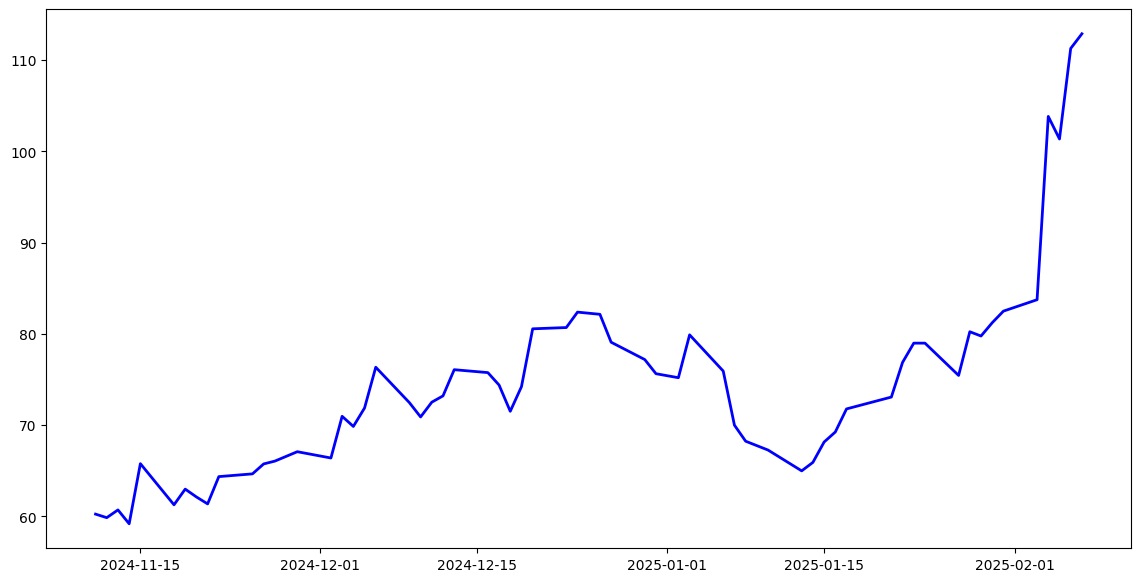

In [44]:
# ======================
# Visualization
# ======================
plt.figure(figsize=(14, 7))

# Historical data
historical_dates = data.index[-days_projection:] if len(data) > days_projection else data.index
plt.plot(historical_dates, closing_prices[-len(historical_dates):], 'b-', lw=2, label='Historical Prices')


In [45]:
# Projection dates
last_date = data.index[-1]
projection_dates = pd.date_range(start=last_date, periods=days_projection+1, freq='B')[1:]


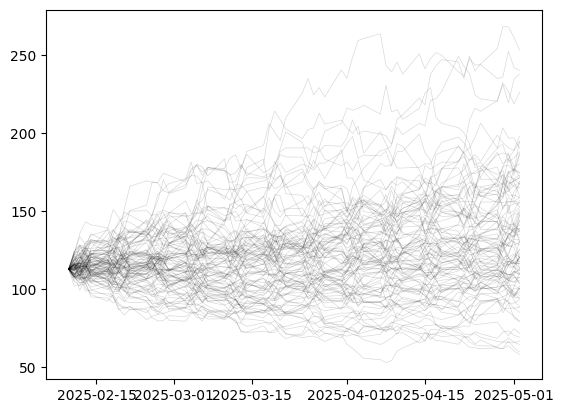

In [46]:
# Plot simulations
for i in range(min(num_simulations, 100)):
    plt.plot(projection_dates, paths[i], lw=0.5, alpha=0.15, color='black')

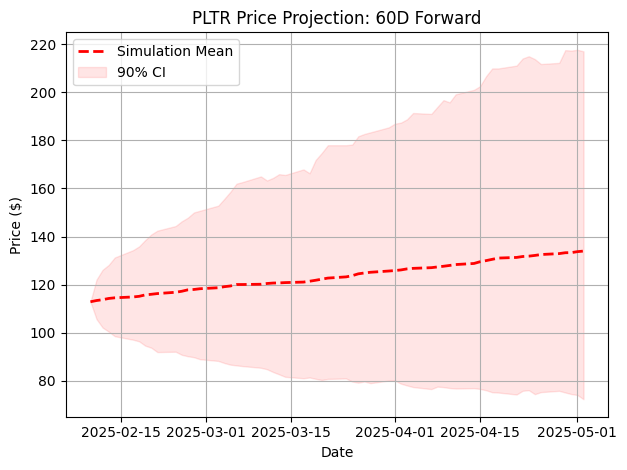

In [47]:
# Plot statistics
mean_path = np.mean(paths, axis=0)
plt.plot(projection_dates, mean_path, 'r--', lw=2, label='Simulation Mean')
plt.fill_between(projection_dates,
                 np.percentile(paths, 5, axis=0),
                 np.percentile(paths, 95, axis=0),
                 color='red', alpha=0.1, label='90% CI')

plt.title(f'{ticker} Price Projection: {projection_period} Forward')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# ======================
# Final Statistics
# ======================
final_prices = paths[:, -1]
print(f"\nProjection Statistics ({projection_period} forward):")
print(f"Mean price: ${np.mean(final_prices):.2f}")
print(f"Price Range: ${np.percentile(final_prices, 5):.2f} to ${np.percentile(final_prices, 95):.2f} (90% CI)")
print(f"Potential Upside: {(np.percentile(final_prices, 95)/S0 - 1)*100:.1f}%")
print(f"Potential Downside: {(np.percentile(final_prices, 5)/S0 - 1)*100:.1f}%")


Projection Statistics (60D forward):
Mean price: $133.96
Price Range: $72.38 to $216.97 (90% CI)
Potential Upside: 92.2%
Potential Downside: -35.9%
